# Content and Objectives

- Show pulse shaping (rect and raised-cosine) for random data
- Spectra are determined based on the theoretical pulse shape as well as for the random signals when applying estimation

# Import

In [1]:
# importing
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=False)

matplotlib.rc('figure', figsize=(18, 10) )

# Define RGB color (Red)
KIT_green = (0, .58, 0.51)  # (R, G, B) -> Red
KIT_blue = ( .27, .39, .66 )

# Getting impulse response of an RC filter and an RRC filter

In [3]:
# find impulse response of an RC filter
def get_rc_ir(K, n_sps, t_symbol, beta):
    
    ''' 
    Determines coefficients of an RC filter 
    
    Formula out of: K.-D. Kammeyer, Nachrichtenübertragung
    At poles, l'Hospital was used 
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''

    # check that IR length is odd
    assert K % 2 == 1, 'Length of the impulse response should be an odd number'
    
    # map zero r to close-to-zero
    if beta == 0:
        beta = 1e-32


    # initialize output length and sample time
    rc = np.zeros( K )
    t_sample = t_symbol / n_sps
    
    
    # time indices and sampled time
    k_steps = np.arange( -(K-1) / 2.0, (K-1) / 2.0 + 1 )   
    t_steps = k_steps * t_sample
    
    for k in k_steps.astype(int):
        
        if t_steps[k] == 0:
            rc[ k ] = 1. / t_symbol
            
        elif np.abs( t_steps[k] ) == t_symbol / ( 2.0 * beta ):
            rc[ k ] = beta / ( 2.0 * t_symbol ) * np.sin( np.pi / ( 2.0 * beta ) )
            
        else:
            rc[ k ] = np.sin( np.pi * t_steps[k] / t_symbol ) / np.pi / t_steps[k] \
                * np.cos( beta * np.pi * t_steps[k] / t_symbol ) \
                / ( 1.0 - ( 2.0 * beta * t_steps[k] / t_symbol )**2 )
 
    return rc

In [4]:
# find impulse response of an RRC filter
def get_rrc_ir(K, n_up, t_symbol, beta):
    
    ''' 
    Determines coefficients of an RRC filter 
    
    Formula out of: J. Huber, Trelliscodierung, Springer, 1992, S. 15
    
    NOTE: roll-off factor must not equal zero
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''
    
    if beta == 0:
        raise ValueError('Roll-off factor must not equal zero!')
    
    K = int(K) 

    if ( K%2 == 0):
        raise ValueError('Length of the impulse response should be an odd number')
    
        
    # initialize np.array    
    rrc = np.zeros( K )
    
    # find sample time and initialize index vector
    t_sample = t_symbol / n_up
    time_ind = range( -(K-1)//2, (K-1)//2+1)

    # assign values of rrc
    for t_i in time_ind:
        t = (t_i)* t_sample    

        if t_i==0:
            rrc[ int( t_i+(K-1)//2 ) ] = (1-beta+4*beta/np.pi)

        elif np.abs(t)==t_symbol/(4*beta):
            # out of wikipedia.de
            #rrc[ t_i+(K-1)/2 ] = beta/np.sqrt(2*t_symbol) * ( (1+2/np.pi)*np.sin(np.pi/(4*beta)) + (1-2/np.pi)*np.cos(np.pi/(4*beta)) )

            # own calculation                
            rrc[ int( t_i+(K-1)//2 ) ] = beta*np.sin(np.pi/(4*beta)*(1+beta)) - 2*beta/np.pi*np.cos(np.pi/(4*beta)*(1+beta)) 

        else:
            rrc[ int( t_i+(K-1)//2 ) ] = (4*beta*t/t_symbol * np.cos(np.pi*(1+beta)*t/t_symbol) + np.sin(np.pi*(1-beta)*t/t_symbol) ) / (np.pi*t/t_symbol*(1-(4*beta*t/t_symbol)**2) )

    rrc = rrc  / np.sqrt(t_symbol)
               
    return rrc  

# Parameters

In [5]:
# modulation scheme and constellation points
M = 2
constellation_points = [ -1, 1 ]

# symbol time and number of symbols    
t_symb = 1.0
n_symb = 20
 

# parameters of the RRC filter
beta = .33

n_sps = 8            # samples per symbol
syms_per_filt = 4  # symbols per filter (plus minus in both directions)

K_filt = 2 * syms_per_filt * n_sps + 1         # length of the fir filter


# parameters for frequency regime
N_fft = 512
Omega = np.linspace( -np.pi, np.pi, N_fft)
f_vec = Omega / ( 2 * np.pi * t_symb / n_sps )

In [6]:
# generate random binary vector and 
# modulate the specified modulation scheme
data = np.random.randint( M, size = n_symb )
A = [ constellation_points[ d ] for d in data ]

# alternatively
A = np.random.choice( constellation_points, size = n_symb, p = (.25, .75 ) )

# parameters for rrc
beta = 0.33
beta_vec = [0.05, .33, .66, .95]

# set time resp. pulse interval and related parameters
t_min = 0.0
t_max = float(n_symb)
t_s = 0.1                                 # sample time
t = np.arange(t_min, t_max+t_s, t_s)

t_symb = 1.0 

# Signals and their spectra

### Ideal sinc

C:\Users\jaekel\AppData\Local\Temp\ipykernel_22508\2195054409.py:8: RuntimeWarning: invalid value encountered in divide
  pulse = np.sin( argument ) / argument


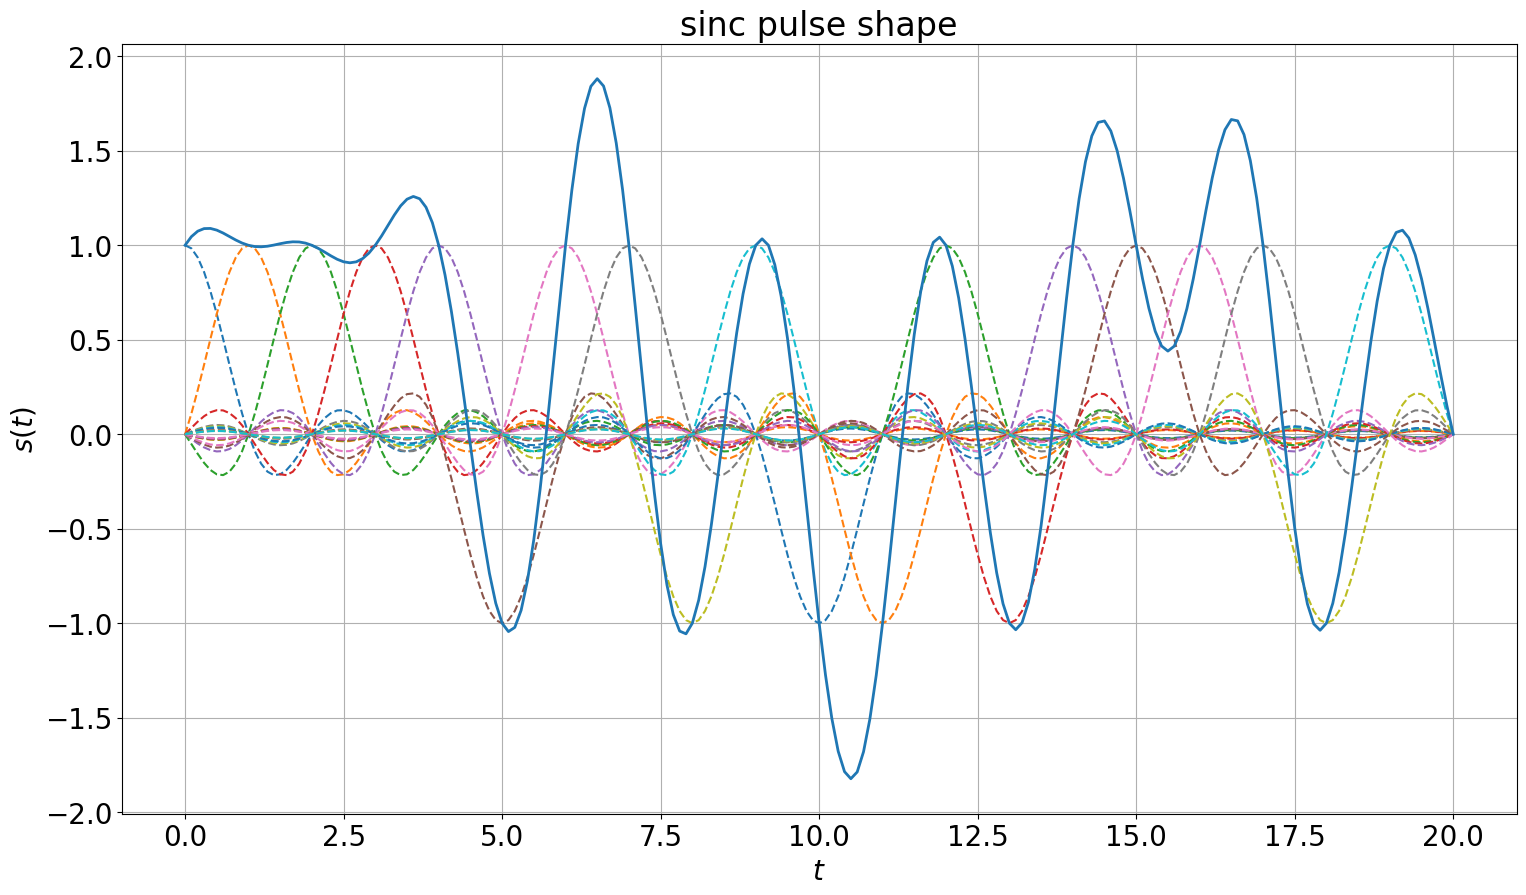

In [7]:
fig, ax = plt.subplots()
    
s = np.zeros( np.shape(t), dtype=complex)

for k in np.arange(0, n_symb):
    argument = np.pi/t_symb*(t-k*t_symb)

    pulse = np.sin( argument ) / argument
    positions_nan = np.isnan(pulse)
    pulse[ positions_nan ] = 1

    mod_pulse = A[k] * pulse
    s += mod_pulse

    plt.plot(t, np.real(mod_pulse),'--')    
    
ax.set_prop_cycle(None)  # Resets the color cycle to start from C0

plt.plot(t, np.real(s), color="C0", linewidth=2.0)
plt.grid(True); plt.xlabel('$t$');  plt.ylabel('$s(t)$'); plt.title('sinc pulse shape')
plt.show()

### Ideal RC 

C:\Users\jaekel\AppData\Local\Temp\ipykernel_22508\46379749.py:9: RuntimeWarning: invalid value encountered in divide
  pulse = np.sin(np.pi*(t-k*t_symb)/t_symb)/(np.pi*(t-k*t_symb)/t_symb) * (np.cos(np.pi*bet*(t-k*t_symb)/t_symb))/(1-4*bet**2*(t-k*t_symb)**2/t_symb**2)


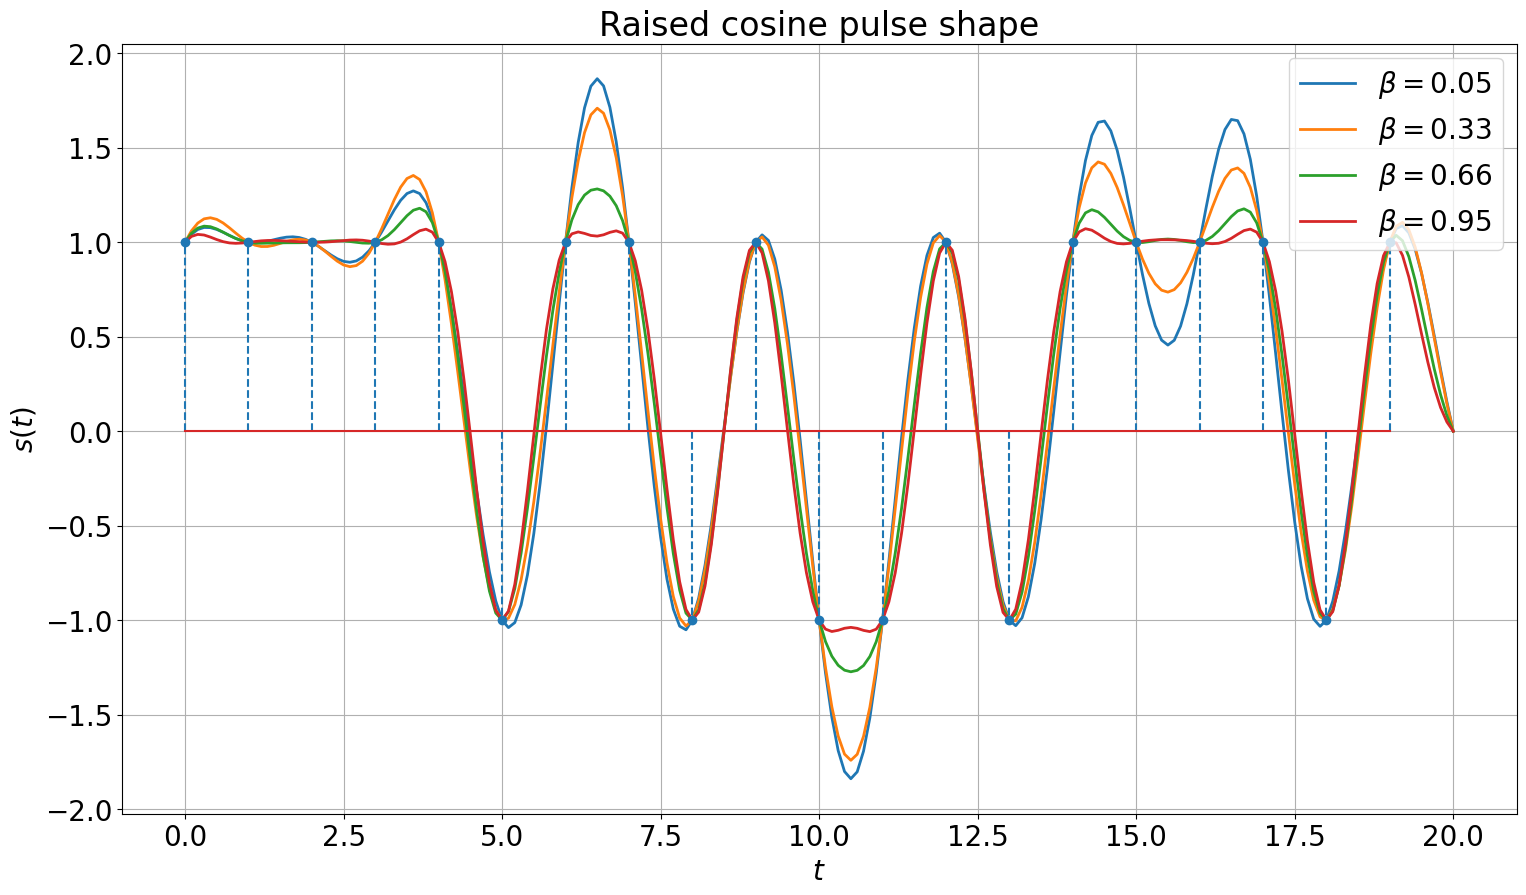

In [8]:
fig, ax = plt.subplots()
        
for bet in beta_vec:
    
    s = np.zeros(np.shape(t), dtype=complex)
    
    for k in np.arange(0, n_symb):

        pulse = np.sin(np.pi*(t-k*t_symb)/t_symb)/(np.pi*(t-k*t_symb)/t_symb) * (np.cos(np.pi*bet*(t-k*t_symb)/t_symb))/(1-4*bet**2*(t-k*t_symb)**2/t_symb**2)
        
        positions_nan = np.isnan(pulse)
        pulse[ positions_nan ] = 1       
        positions_inf = np.isinf(pulse)
        pulse[ positions_inf ] = 1
        
        mod_pulse = A[k] * pulse
        s += mod_pulse

    plt.plot(t, np.real(s), label='$\\beta=$'+str(bet), linewidth=2.0)  
    
ax.set_prop_cycle(None)  # Resets the color cycle to start from C0

plt.stem( np.arange(n_symb), np.real(A), '--')

plt.grid(True); plt.xlabel('$t$');  plt.ylabel('$s(t)$'); plt.legend(loc='upper right')
plt.title('Raised cosine pulse shape')
plt.show()

### Causal RRC 

In [9]:
n_up = 8            # samples per symbol

syms_per_filt = 4  # symbols per filter (plus minus in both directions)

K_filt = 2*syms_per_filt*n_up+1         # length of the fir filter

# prepare sequence to be filtered
s_up = np.zeros(n_symb*n_up, dtype=complex)        
s_up[::n_up] = A
s_up = np.append(s_up, np.zeros(K_filt-1))        

#####
# apply rrc        
#####
rrc = get_rrc_ir(n_up*syms_per_filt*2+1, n_up, t_symb, beta)
E_rrc = np.sum(np.abs(rrc)**2)

rrc = rrc/np.sqrt(E_rrc)
s_filt_rrc = signal.lfilter(rrc, [1], s_up)

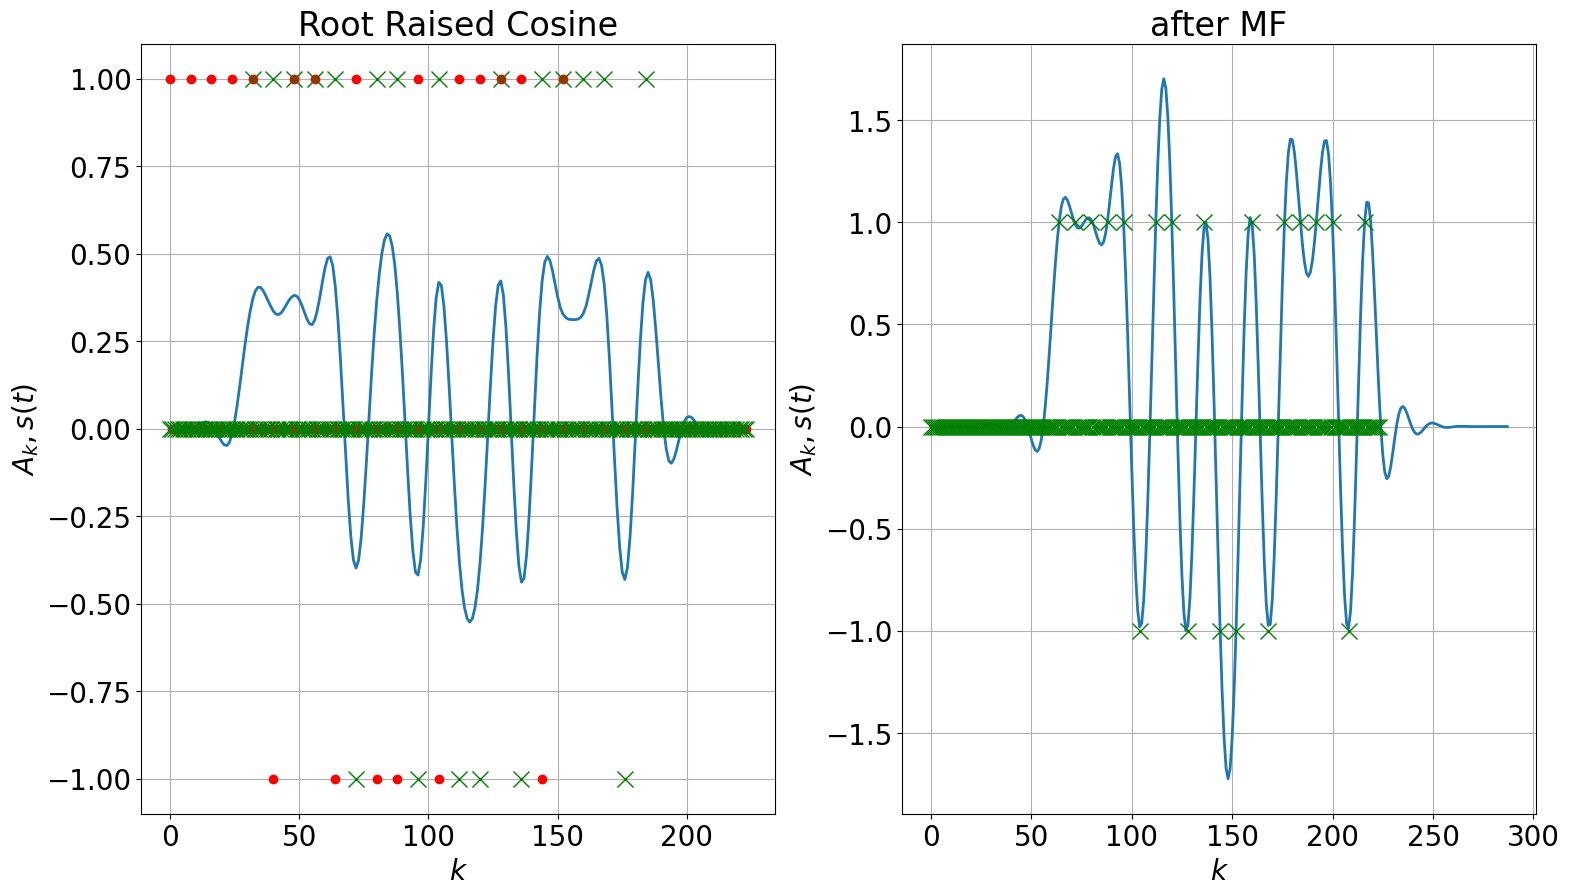

In [10]:
plt.figure()

K = n_symb*n_up+K_filt-1     
        
plt.subplot(121)
plt.plot( np.arange(K), np.real(s_up),'ro')
plt.plot( np.arange(K), np.real(s_filt_rrc), linewidth=2.0, label='Root Raised Cosine')  

plt.plot( np.arange(K), np.roll( np.real(s_up), (K_filt - 1 ) // 2 ) , 'gx', ms=12 )        

plt.title('Root Raised Cosine')
plt.grid(True); plt.xlabel('$k$');  plt.ylabel('$A_k, s(t)$')   

       
plt.subplot(122)

after_mf = np.convolve( s_filt_rrc, rrc)
plt.plot( np.real( after_mf ), linewidth=2.0, label='Root Raised Cosine')  
plt.plot( np.arange(K), np.roll( np.real(s_up), (K_filt - 1 ) ) , 'gx', ms=12 )        

plt.title('after MF')
plt.grid(True); plt.xlabel('$k$');  plt.ylabel('$A_k, s(t)$')   

plt.show() 